In [1]:
from IPython.display import display
import ipywidgets
import importlib
import utils
import PIL
import numpy as np

In [2]:
def custom_underline_checker(char_img: PIL.Image) -> bool:
    char_img = char_img.crop((0, char_img.height*0.82, char_img.width, 0.9*char_img.height))
    char_np = np.array(char_img.convert('L'))
    balck_pixels = np.count_nonzero(char_np <= 50)
    total_pixels = char_np.shape[0] * char_np.shape[1]
    black_percentage = balck_pixels / total_pixels
    return black_percentage > 0.6

def custom_char_modifier(char, char_img):
    if char.rect.width() < 1 or char.rect.height() < 1:
        return
    char.underlined = custom_underline_checker(char_img)

In [4]:
importlib.reload(utils)
doc = utils.PdfDocument('ado26.pdf')
page = doc.get_page(24)
img1 = page.highlight_chars()
page.apply_char_modifier_function(custom_char_modifier)
img2 = page.highlight_chars()
#img1.thumbnail((1000, 1000), PIL.Image.LANCZOS)
#img2.thumbnail((1000, 1000), PIL.Image.LANCZOS)
#utils.display_pil([img1, img2])

# Note: the dots on the image show size-less characters (e.g. '\n')

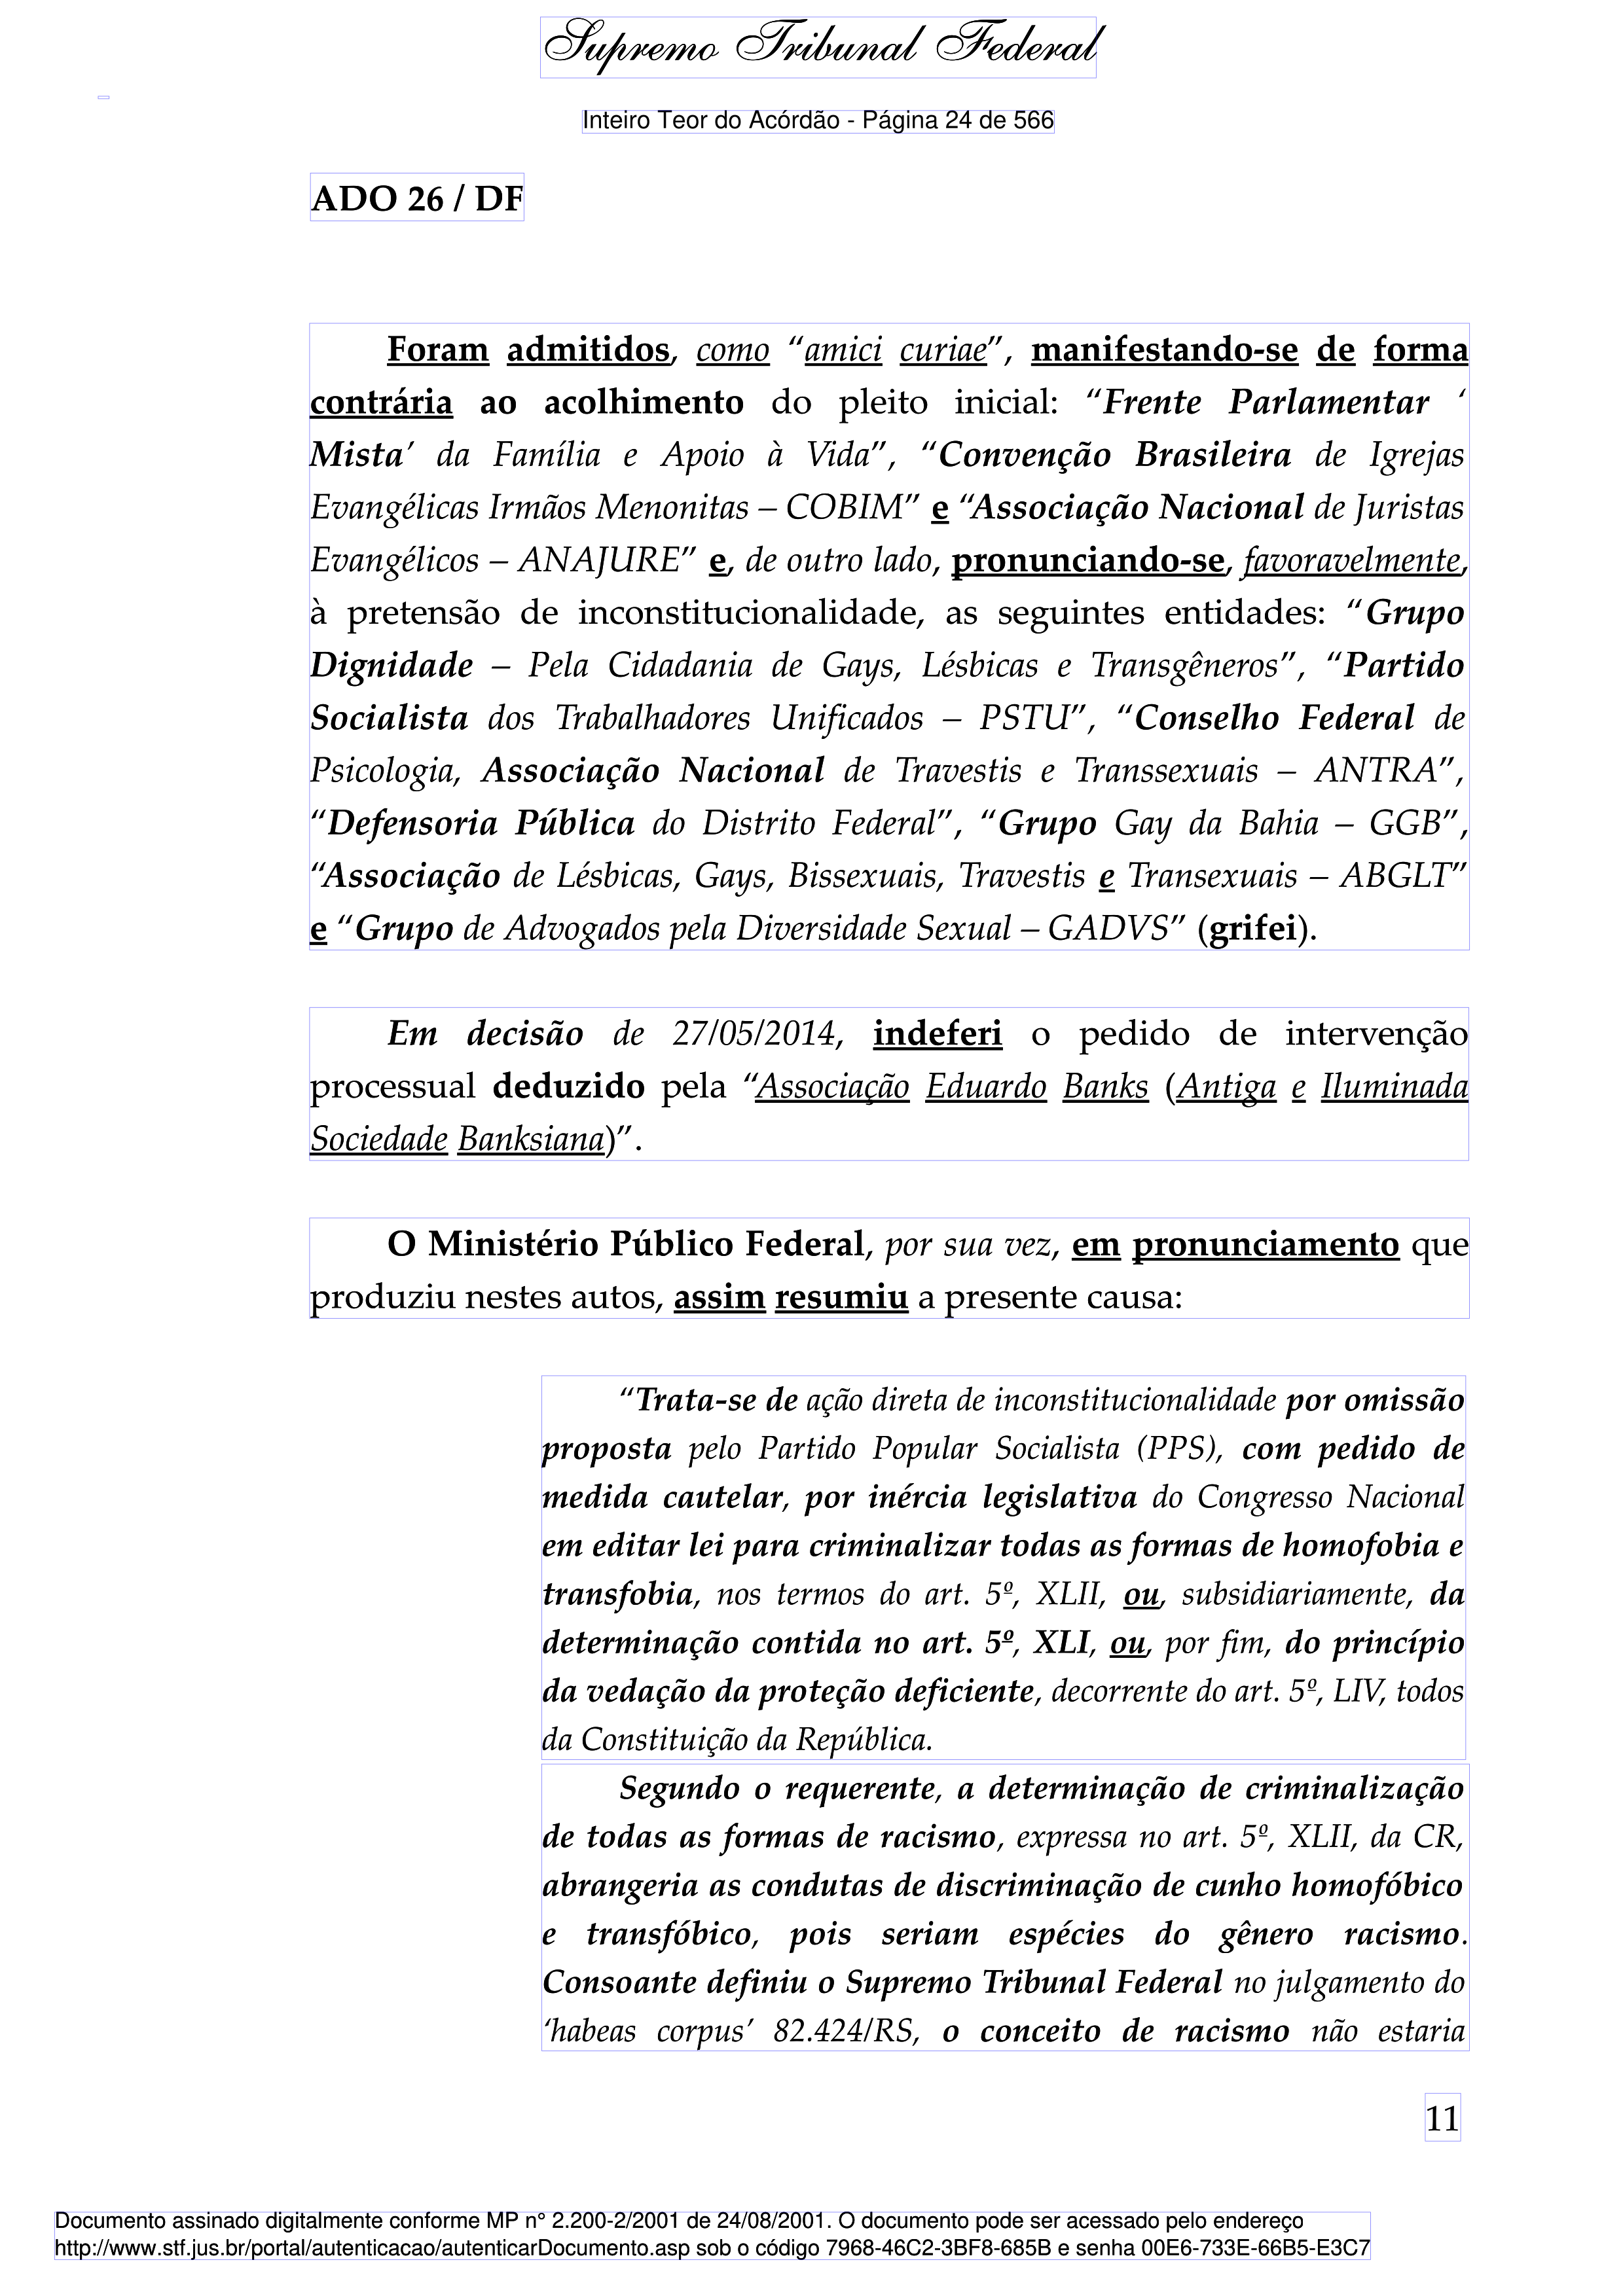

In [117]:
# Group Lines

importlib.reload(utils)
doc = utils.PdfDocument('ado26.pdf')
page = doc.get_page(24)
blocks = page.blocks()
paragraphs = utils.TextBlock.split_by_indent(blocks)
page.highlight_things(paragraphs)

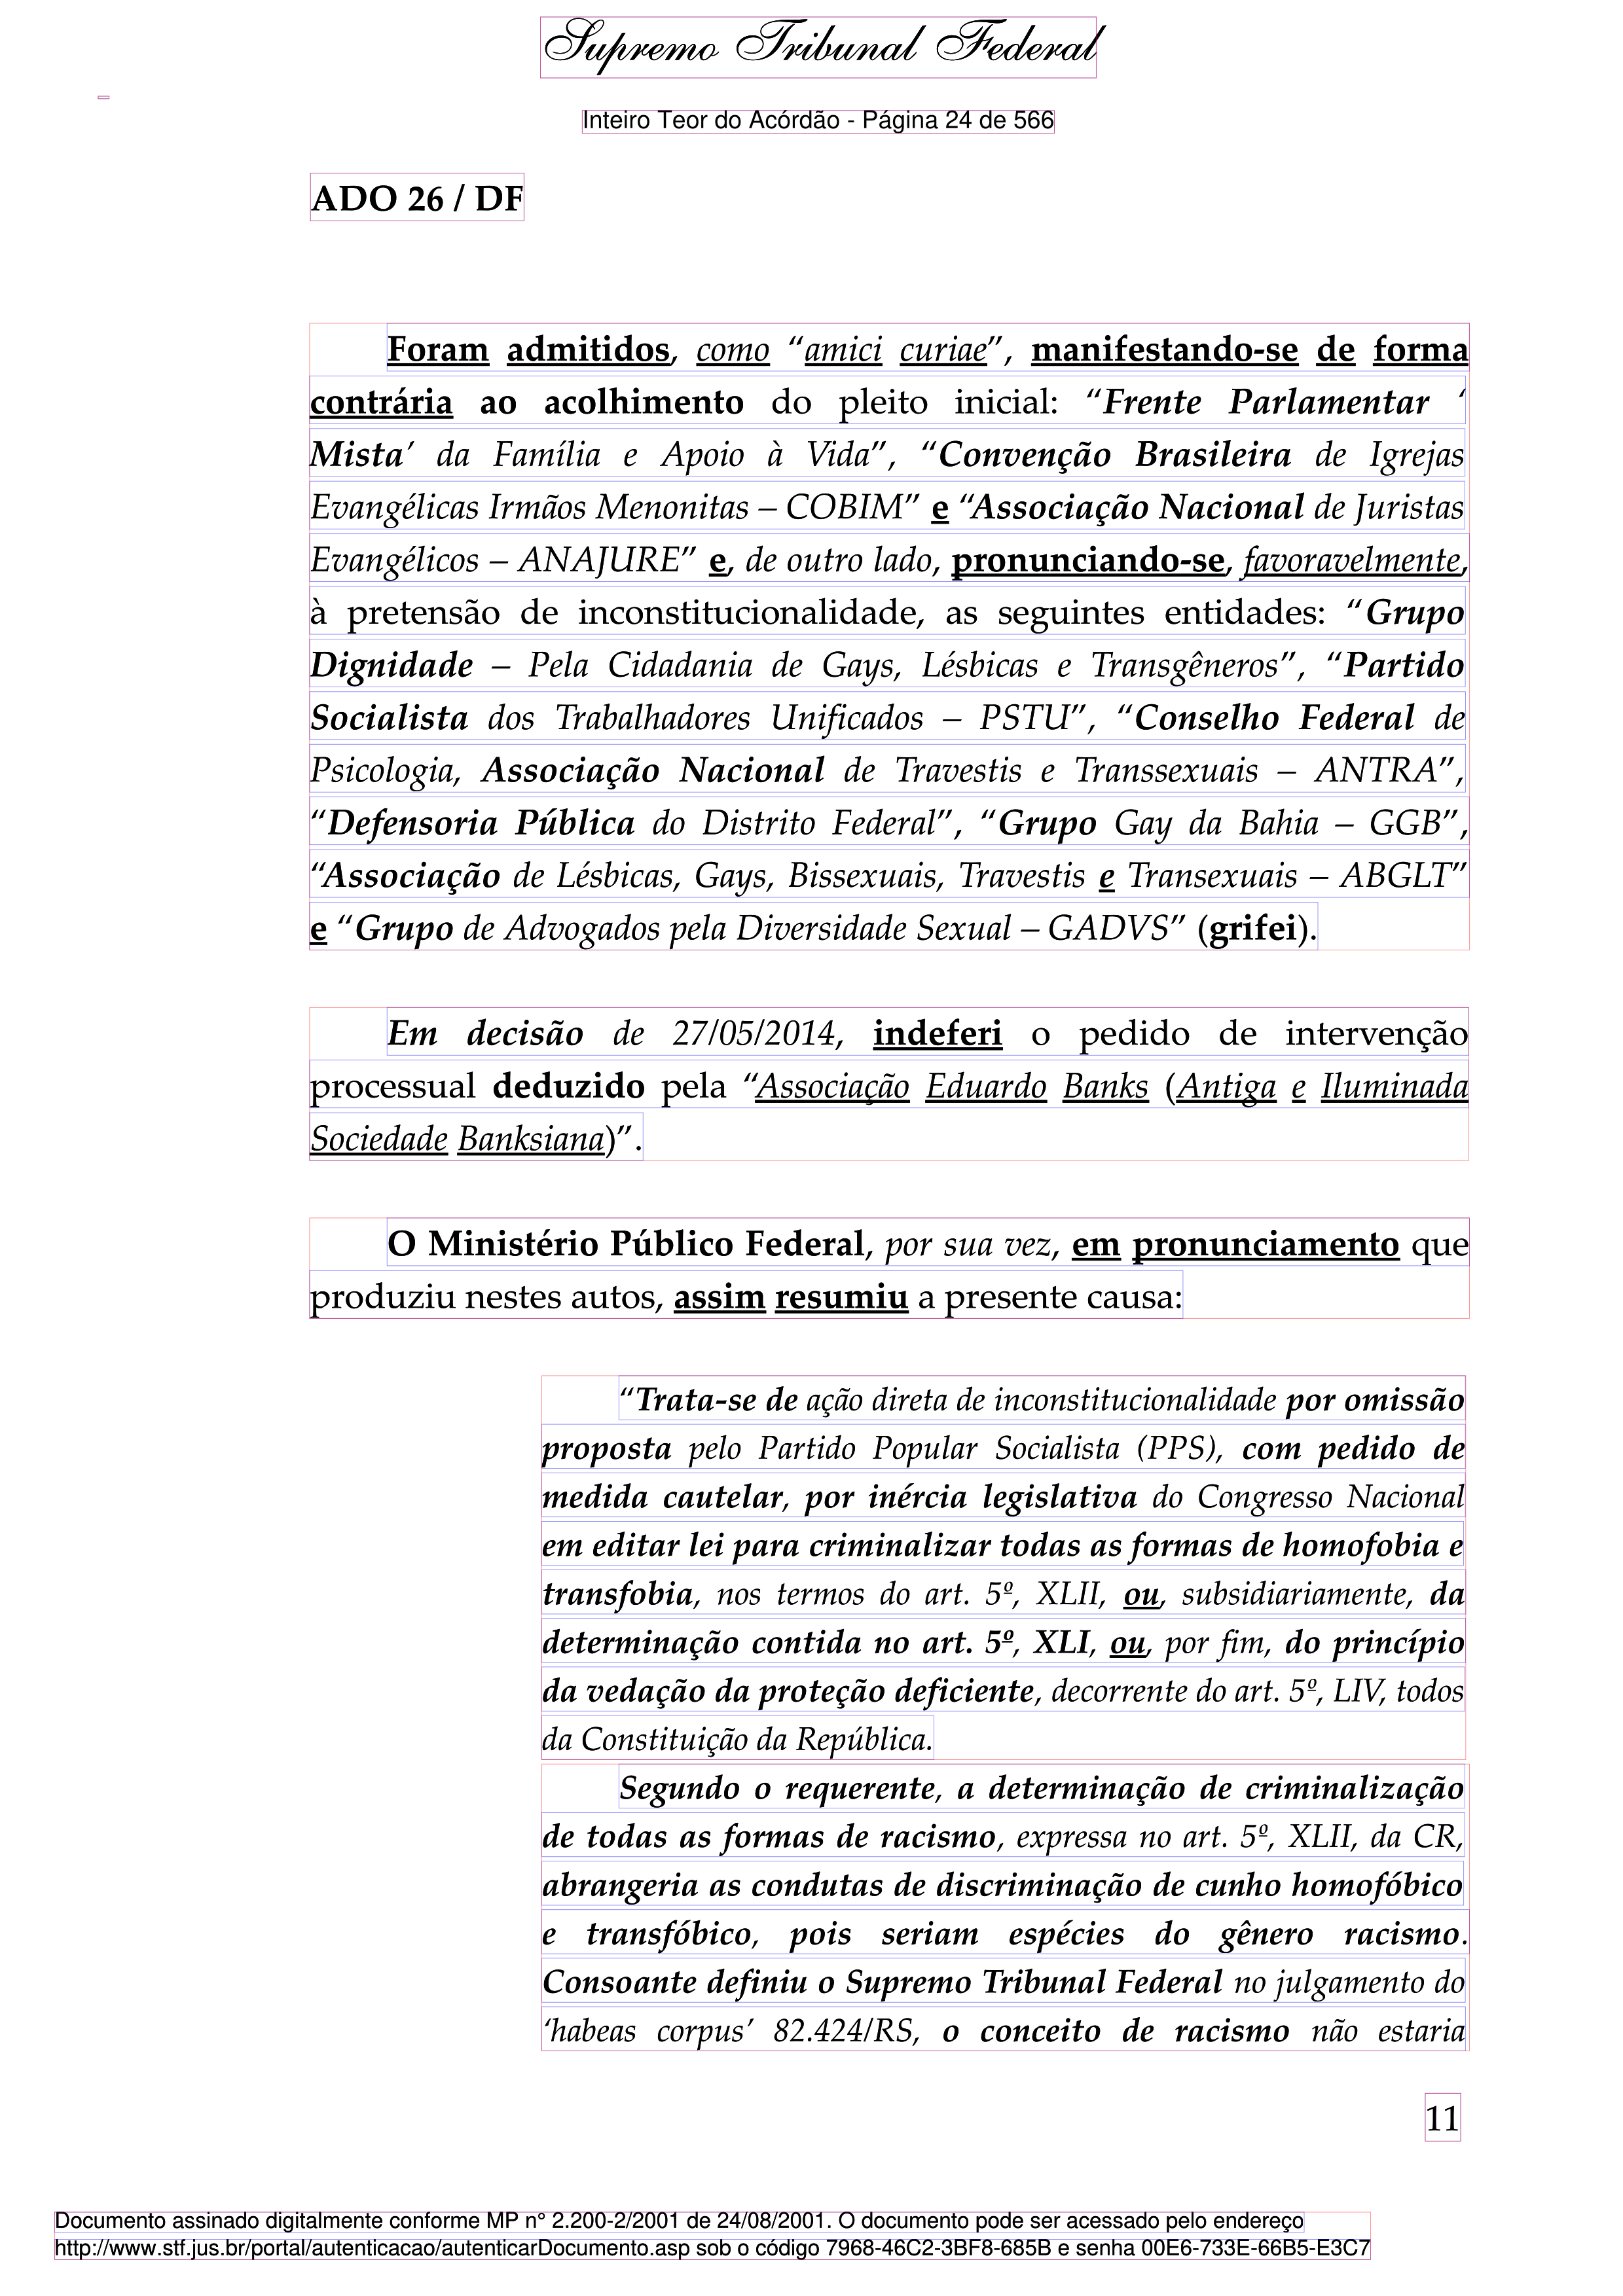

In [89]:
importlib.reload(utils)
doc = utils.PdfDocument('ado26.pdf')
page = doc.get_page(24)
chars = page.chars()

last_char = chars[0]
lines = [{'rect': last_char.rect, 'text': last_char.text, 'color': utils.Color(0,0,1)}]
for char in chars[1:]:
    dist = last_char.rect.distance_to(char.rect)
    if dist < 1:
        lines[-1]['text'] += char.text
        lines[-1]['rect'] = lines[-1]['rect'].union(char.rect)
    else:
        lines.append({'rect': char.rect, 'text': char.text, 'color': utils.Color(0,0,1)})
    last_char = char
    
last_line = lines[0]
blocks = [{'rect': last_line['rect'], 'lines': [last_line], 'color': utils.Color(1,0,0)}]
for line in lines[1:]:
    dist = last_line['rect'].distance_to(line['rect'])
    #indent = blocks[-1]['rect'].left - line['rect'].left
    #print(indent, line['text'])
    if dist < 5:
        blocks[-1]['lines'] += [line]
        blocks[-1]['rect'] = blocks[-1]['rect'].union(line['rect'])
    else:
        blocks.append({'rect': line['rect'], 'lines': [line], 'color': utils.Color(1,0,0)})
    last_line = line
    
old_blocks, blocks = blocks, []
for block in old_blocks:
    for i, line in enumerate(block['lines']):
        indent = line['rect'].left - block['rect'].left
        new_paragraph = indent > 25 or i == 0
        if new_paragraph:
            blocks.append({'rect': line['rect'], 'lines': [line], 'color': utils.Color(1,0,0)})
        else:
            blocks[-1]['lines'].append(line)
            blocks[-1]['rect'] = blocks[-1]['rect'].union(line['rect'])

    
page.highlight_things(lines+blocks)